In [1]:
import json
from pathlib import Path

import numpy as np
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import r2_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


def set_seed(seed: int = 42) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
from google.colab import drive
drive.mount("/content/drive")
BASE_DIR = "/content/drive/MyDrive/data/maestro-patch64-block10-42"

Using device: cuda
Mounted at /content/drive


In [2]:
configs = {
    # data
    "batch_size": 8,

    # model
    "base_channels": 0,
    "dropout": 0,

    # training
    "epochs": 0,
    "patience": 0,
    "base_lr": 0,
    "max_lr": 0,
    "weight_decay": 0,
    "scheduler": None,  # or None

    # multi-task loss weights
    "seg_weight": 0,
    "height_weight": 0,
    "biomass_weight": 0,
}


IGNORE_INDEX = -1  # for segmentation ignore_index
S1_MIN_THRESHOLD = 999  # dB clipping for Sentinel-1 backscatter
S1_MAX_THRESHOLD = -999

RARE_GENUS_NAMES = {
    "betula",
    "castanea",
    "corylus",
    "robinia",
    "sorbus",
    "salix",
    "prunus",
    "larix",
    "populus",
    "malus",
    "ulmus",
    "crataegus",

    "tilia",
    "acer",
    "alnus",
    "carpinus"
}

## Load Data

### Loader Functions

In [3]:
def compute_ignored_seg_class_indices(code_to_index: dict[int, int]) -> list[int]:
    ignored: set[int] = set()
    genus_map_path = BASE_DIR+"/genus_map.json"
    with open(genus_map_path, "r", encoding="utf-8") as f:
        genus_to_code = json.load(f)
    genus_to_code_lc = {k.lower(): int(v) for k, v in genus_to_code.items()}

    for g in RARE_GENUS_NAMES:
        code = genus_to_code_lc.get(g.lower())
        if code is None:
            print(f"[Warning] Genus '{g}' not found in genus_map; skipping.")
            continue
        if code not in code_to_index:
            continue
        ignored.add(code_to_index[code])

    ignored_list = sorted(ignored)
    if ignored_list:
        print("Segmentation classes to ignore (indices):", ignored_list)
    else:
        print("No segmentation classes will be ignored (rare genus not present in patches).")

    return ignored_list

In [4]:
def load_all_patches(base_dir: str):
    base_path = Path(base_dir)
    patches_train = np.load(base_path / "patches_train.npy")  # (N, 5, 64, 64)
    patches_val = np.load(base_path / "patches_val.npy")
    patches_test = np.load(base_path / "patches_test.npy")

    # Channel order in patches_: 0: VH, 1: VV, 2: biomass, 3: genus, 4: height
    genus_train = patches_train[:, 3, ...]
    genus_val = patches_val[:, 3, ...]
    genus_test = patches_test[:, 3, ...]

    all_genus = np.concatenate(
        [genus_train.reshape(-1), genus_val.reshape(-1), genus_test.reshape(-1)]
    )
    mask = np.isfinite(all_genus) & (all_genus > 0)
    codes = np.unique(all_genus[mask].astype(int))
    codes_sorted = sorted(int(c) for c in codes)
    code_to_index = {code: idx for idx, code in enumerate(codes_sorted)}
    index_to_code = {idx: code for code, idx in code_to_index.items()}

    print("Genus codes used in dataset (code -> index):")
    print(code_to_index)

    return (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    )


class IMAESTROSegDataset(Dataset):
    """Dataset for multi-task learning on 64x64 patches.

    Inputs:
        - x: Sentinel-1 VH/VV (2 channels), clipped to [S1_MIN_THRESHOLD, S1_MAX_THRESHOLD].
    Targets:
        - y_seg: genus segmentation, shape (H, W), with labels in [0, num_classes-1]
                 and IGNORE_INDEX for invalid pixels.
        - y_height: height95 map, shape (1, H, W), NaN for invalid pixels.
        - y_biomass: biomass_t_ha map, shape (1, H, W), NaN for invalid pixels.
    """

    def __init__(
        self,
        patches: np.ndarray,
        code_to_index: dict[int, int],
        ignore_index: int = IGNORE_INDEX,
        ignore_class_indices: list[int] | None = None,
    ) -> None:
        super().__init__()

        if patches.ndim != 4:
            raise ValueError(f"Expected patches of shape (N, C, H, W), got {patches.shape}")

        vh = patches[:, 0, ...].astype(np.float32)
        vv = patches[:, 1, ...].astype(np.float32)
        s1 = np.stack([vh, vv], axis=1)

        biomass = patches[:, 2, ...].astype(np.float32)
        genus_raw = patches[:, 3, ...].astype(np.float32)
        height = patches[:, 4, ...].astype(np.float32)

        # Handle NaN / NoData for regression targets
        def _clean_reg_target(arr: np.ndarray) -> np.ndarray:
            out = arr.copy()
            # Treat very negative values (e.g., -9999) as invalid
            mask_invalid = ~np.isfinite(out) | (out < -1e3)
            out[mask_invalid] = np.nan
            return out

        biomass = _clean_reg_target(biomass)
        height = _clean_reg_target(height)

        # Genus segmentation: map codes -> contiguous indices, others -> IGNORE_INDEX
        genus = np.full_like(genus_raw, ignore_index, dtype=np.int64)
        valid_mask = np.isfinite(genus_raw) & (genus_raw > 0)
        genus_int = genus_raw[valid_mask].astype(int)

        # Vectorized mapping from code to index
        if len(code_to_index) > 0:
            mapped = np.vectorize(lambda c: code_to_index.get(int(c), ignore_index))(
                genus_int
            )
            genus[valid_mask] = mapped
        # Further ignore specified rare classes by mapping them to IGNORE_INDEX
        if ignore_class_indices is not None and len(ignore_class_indices) > 0:
            ignore_arr = np.array(ignore_class_indices, dtype=np.int64)
            mask_rare = np.isin(genus, ignore_arr)
            if mask_rare.any():
                genus[mask_rare] = ignore_index

        self.inputs = torch.from_numpy(s1)  # (N, 2, H, W)
        self.seg_targets = torch.from_numpy(genus.astype(np.int64))  # (N, H, W)
        self.height_targets = torch.from_numpy(height).unsqueeze(1)  # (N, 1, H, W)
        self.biomass_targets = torch.from_numpy(biomass).unsqueeze(1)  # ditto

    def __len__(self) -> int:  # type: ignore[override]
        return self.inputs.shape[0]

    def __getitem__(self, idx: int):  # type: ignore[override]
        x = self.inputs[idx]
        y_seg = self.seg_targets[idx]
        y_h = self.height_targets[idx]
        y_b = self.biomass_targets[idx]
        return x, y_seg, y_h, y_b


def make_datasets(base_dir: str):
    (
        patches_train,
        patches_val,
        patches_test,
        code_to_index,
        index_to_code,
    ) = load_all_patches(base_dir)

    ignored_seg_class_indices = compute_ignored_seg_class_indices(code_to_index)

    train_ds = IMAESTROSegDataset(
        patches_train,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )
    val_ds = IMAESTROSegDataset(
        patches_val,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )
    test_ds = IMAESTROSegDataset(
        patches_test,
        code_to_index,
        IGNORE_INDEX,
        ignore_class_indices=ignored_seg_class_indices,
    )

    print("Train:", len(train_ds), "Val:", len(val_ds), "Test:", len(test_ds))
    num_classes = len(code_to_index)
    return (
        train_ds,
        val_ds,
        test_ds,
        num_classes,
        code_to_index,
        index_to_code,
        ignored_seg_class_indices,
    )

In [5]:
def visualize_dataset_triplet_sample(
    train_ds: IMAESTROSegDataset,
    val_ds: IMAESTROSegDataset,
    test_ds: IMAESTROSegDataset,
    idx_train: int = 0,
    idx_val: int = 0,
    idx_test: int = 0,
    num_classes: int = 0,
) -> None:
    """Visualize one sample from train/val/test datasets.

    Each row corresponds to a split (Train / Val / Test) and shows:
        VV, VH, genus segmentation (index), height, biomass.
    """

    samples = [
        ("Train", train_ds, int(idx_train)),
        ("Val", val_ds, int(idx_val)),
        ("Test", test_ds, int(idx_test)),
    ]

    n = len(samples)

    fig, axes = plt.subplots(nrows=n, ncols=5, figsize=(3 * 5, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row, (split_name, ds, idx) in enumerate(samples):
        ax_row = axes[row]
        x, y_seg, y_h, y_b = ds[idx]

        x_np = x.cpu().numpy()
        y_seg_np = y_seg.cpu().numpy()
        y_h_np = y_h.cpu().numpy()[0]
        y_b_np = y_b.cpu().numpy()[0]

        vv = x_np[1, :, :]
        vh = x_np[0, :, :]
        seg = y_seg_np.copy()

        mask_invalid = ~np.isfinite(seg) | (seg == IGNORE_INDEX)
        seg = np.ma.array(seg, mask=mask_invalid)

        images = [vv, vh, seg, y_h_np, y_b_np]
        titles = ["VV", "VH", "Genus index", "Height", "Biomass"]

        for col in range(5):
            ax = ax_row[col]
            band = images[col]

            if col in (0, 1):
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            elif col == 2:
                cmap = "tab20"
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )
            else:
                cmap = "viridis"
                im = ax.imshow(band, cmap=cmap)

            if row == 0:
                ax.set_title(titles[col])
            if col == 0:
                ax.set_ylabel(split_name)
            ax.axis("off")

            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

### data

In [6]:
train_ds, val_ds, test_ds, num_classes, code_to_index, index_to_code, ignored_seg_class_indices = make_datasets(BASE_DIR)

train_loader = DataLoader(train_ds, batch_size=configs["batch_size"], shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=configs["batch_size"], shuffle=False, num_workers=2)
test_loader = DataLoader(test_ds, batch_size=configs["batch_size"], shuffle=False, num_workers=2)

Genus codes used in dataset (code -> index):
{1: 0, 2: 1, 4: 2, 5: 3, 7: 4, 8: 5, 9: 6, 10: 7, 11: 8, 13: 9, 16: 10, 17: 11, 19: 12, 20: 13, 21: 14, 22: 15, 25: 16, 26: 17, 27: 18, 28: 19, 30: 20, 31: 21}
Segmentation classes to ignore (indices): [1, 2, 3, 4, 5, 6, 7, 10, 11, 14, 15, 17, 18, 19, 20, 21]
Train: 724 Val: 145 Test: 109


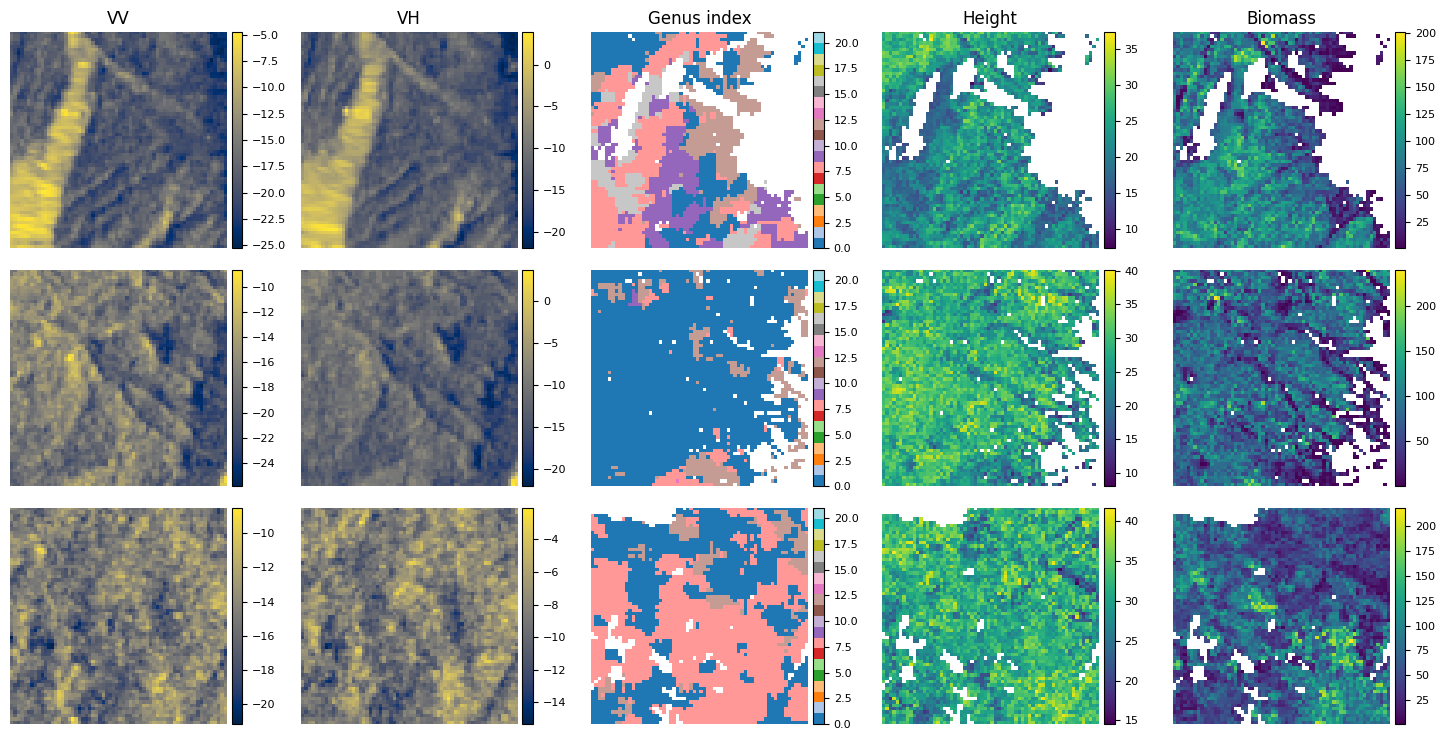

In [7]:
visualize_dataset_triplet_sample(train_ds, val_ds, test_ds, idx_train=72, idx_val=72, idx_test=72, num_classes=num_classes)

## Model

In [8]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Down(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=3,
                stride=2,
                padding=1,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        return self.block(x)


class Up(nn.Module):
    def __init__(self, in_channels: int, out_channels: int) -> None:
        super().__init__()
        self.up = nn.ConvTranspose2d(
            in_channels,
            in_channels // 2,
            kernel_size=2,
            stride=2,
        )
        # after upsampling, features are concatenated with skip connection
        # so DoubleConv expects in_channels and produces out_channels
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x: torch.Tensor, skip: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x = self.up(x)
        # shapes should match exactly (64 -> 32 -> 16 -> 8)
        if x.shape[-2:] != skip.shape[-2:]:
            # simple padding/cropping guard (should rarely trigger)
            min_h = min(x.shape[-2], skip.shape[-2])
            min_w = min(x.shape[-1], skip.shape[-1])
            x = x[..., :min_h, :min_w]
            skip = skip[..., :min_h, :min_w]
        x = torch.cat([x, skip], dim=1)
        x = self.conv(x)
        return x

### Segmentation

In [9]:
class SegmentationUNet(nn.Module):
    """U-Net for genus segmentation only (no regression heads)."""

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        self.num_classes = num_classes

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        self.up3 = Up(base_channels * 8, base_channels * 4)
        self.up2 = Up(base_channels * 4, base_channels * 2)
        self.up1 = Up(base_channels * 2, base_channels)
        self.drop = nn.Dropout2d(p=dropout)
        self.out_seg = nn.Conv2d(base_channels, num_classes, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x1 = self.enc1(x)
        x2 = self.down1(x1)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)
        x5 = self.bottleneck(x4)

        s = self.up3(x5, x3)
        s = self.up2(s, x2)
        s = self.up1(s, x1)
        s = self.drop(s)
        seg_logits = self.out_seg(s)
        return seg_logits

### Regression

In [10]:
class RegressionUNet(nn.Module):
    def __init__(
        self,
        in_channels: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        self.up3 = Up(base_channels * 8, base_channels * 4)
        self.up2 = Up(base_channels * 4, base_channels * 2)
        self.up1 = Up(base_channels * 2, base_channels)
        self.drop = nn.Dropout2d(p=dropout)
        self.out_reg = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:  # type: ignore[override]
        x1 = self.enc1(x)
        x2 = self.down1(x1)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)
        x5 = self.bottleneck(x4)

        r = self.up3(x5, x3)
        r = self.up2(r, x2)
        r = self.up1(r, x1)
        r = self.drop(r)
        preds = self.out_reg(r)  # (N, out_channels, H, W)
        return preds

In [11]:
class MultiTaskUNet(nn.Module):
    """U-Net with shared encoder and three heads:

    - seg_head: genus segmentation (N, num_classes, 64, 64)
    - height_head: height regression (N, 1, 64, 64)
    - biomass_head: biomass regression (N, 1, 64, 64)
    """

    def __init__(
        self,
        in_channels: int,
        num_classes: int,
        base_channels: int = 64,
        dropout: float = 0.2,
    ) -> None:
        super().__init__()

        self.num_classes = num_classes

        # Encoder: 64 -> 32 -> 16 -> 8
        self.enc1 = DoubleConv(in_channels, base_channels)
        self.down1 = Down(base_channels, base_channels * 2)  # 64 -> 32
        self.enc2 = DoubleConv(base_channels * 2, base_channels * 2)
        self.down2 = Down(base_channels * 2, base_channels * 4)  # 32 -> 16
        self.enc3 = DoubleConv(base_channels * 4, base_channels * 4)
        self.down3 = Down(base_channels * 4, base_channels * 8)  # 16 -> 8
        self.bottleneck = DoubleConv(base_channels * 8, base_channels * 8)

        # Segmentation decoder
        self.up3_seg = Up(base_channels * 8, base_channels * 4)
        self.up2_seg = Up(base_channels * 4, base_channels * 2)
        self.up1_seg = Up(base_channels * 2, base_channels)
        self.drop_seg = nn.Dropout2d(p=dropout)
        self.out_seg = nn.Conv2d(base_channels, num_classes, kernel_size=1)

        # Height regression decoder
        self.up3_h = Up(base_channels * 8, base_channels * 4)
        self.up2_h = Up(base_channels * 4, base_channels * 2)
        self.up1_h = Up(base_channels * 2, base_channels)
        self.drop_h = nn.Dropout2d(p=dropout)
        self.out_h = nn.Conv2d(base_channels, 1, kernel_size=1)

        # Biomass regression decoder
        self.up3_b = Up(base_channels * 8, base_channels * 4)
        self.up2_b = Up(base_channels * 4, base_channels * 2)
        self.up1_b = Up(base_channels * 2, base_channels)
        self.drop_b = nn.Dropout2d(p=dropout)
        self.out_b = nn.Conv2d(base_channels, 1, kernel_size=1)

    def forward(self, x: torch.Tensor):  # type: ignore[override]
        # Shared encoder
        x1 = self.enc1(x)  # (N, C, 64, 64)
        x2 = self.down1(x1)  # (N, 2C, 32, 32)
        x2 = self.enc2(x2)
        x3 = self.down2(x2)  # (N, 4C, 16, 16)
        x3 = self.enc3(x3)
        x4 = self.down3(x3)  # (N, 8C, 8, 8)
        x5 = self.bottleneck(x4)

        # Segmentation branch
        s = self.up3_seg(x5, x3)
        s = self.up2_seg(s, x2)
        s = self.up1_seg(s, x1)
        s = self.drop_seg(s)
        seg_logits = self.out_seg(s)

        # Height branch
        h = self.up3_h(x5, x3)
        h = self.up2_h(h, x2)
        h = self.up1_h(h, x1)
        h = self.drop_h(h)
        height = self.out_h(h)

        # Biomass branch
        b = self.up3_b(x5, x3)
        b = self.up2_b(b, x2)
        b = self.up1_b(b, x1)
        b = self.drop_b(b)
        biomass = self.out_b(b)

        return seg_logits, height, biomass

## Training Functions

### Loss

In [12]:
def masked_rmse_loss(preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """RMSE ignoring NaN values in targets.

    preds, targets: (N, 1, H, W)
    """

    mask = torch.isfinite(targets)
    if not mask.any():
        return (preds * 0.0).sum()
    diff = preds[mask] - targets[mask]
    return torch.sqrt(torch.mean(diff ** 2))

def masked_r2(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    min_target: float | None = 0.0,
) -> float:
    """Compute R² on valid regression targets only (masked by forest pixels).

    - Always忽略非有限值 (NaN / inf)。
    - 如果 ``min_target`` 不为 None，则只在 ``y_true > min_target`` 的像元上计算，
      用于只在有效森林像元上评估。
    """

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if min_target is not None:
        mask &= y_true > float(min_target)

    if not np.any(mask):
        return float("nan")

    y_true_m = y_true[mask]
    y_pred_m = y_pred[mask]

    return float(r2_score(y_true_m, y_pred_m))


In [13]:
def compute_segmentation_metrics(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    num_classes: int,
    ignore_index: int = IGNORE_INDEX,
):
    """Compute pixel accuracy, IoU and Dice for segmentation.

    y_true, y_pred: (N, H, W) integer arrays.
    Pixels with label == ``ignore_index`` in ``y_true`` are ignored everywhere,
    so they do not contribute to loss, metrics, or confusion matrix.
    """

    mask = y_true != ignore_index
    if not mask.any():
        return {
            "pixel_acc": float("nan"),
            "mean_iou": float("nan"),
            "per_class_iou": [float("nan")] * num_classes,
            "mean_dice": float("nan"),
            "per_class_dice": [float("nan")] * num_classes,
            "per_class_acc": [float("nan")] * num_classes,
        }

    y_true_flat = y_true[mask].ravel()
    y_pred_flat = y_pred[mask].ravel()

    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))
    correct = np.diag(cm).astype(float)
    total = cm.sum().astype(float)
    pixel_acc = float(correct.sum() / total) if total > 0 else float("nan")

    # Per-class accuracy: TP / (TP + FN)
    row_sum = cm.sum(axis=1).astype(float)
    per_class_acc = np.where(row_sum > 0, correct / (row_sum + 1e-6), np.nan)

    # IoU per class
    union = cm.sum(axis=1) + cm.sum(axis=0) - correct
    iou = np.where(union > 0, correct / (union + 1e-6), np.nan)
    mean_iou = float(np.nanmean(iou))

    # Dice per class: 2TP / (2TP + FP + FN) = 2TP / (row + col)
    col_sum = cm.sum(axis=0).astype(float)
    denom = row_sum + col_sum
    dice = np.where(denom > 0, 2.0 * correct / (denom + 1e-6), np.nan)
    mean_dice = float(np.nanmean(dice))

    return {
        "pixel_acc": pixel_acc,
        "mean_iou": mean_iou,
        "per_class_iou": iou.tolist(),
        "mean_dice": mean_dice,
        "per_class_dice": dice.tolist(),
        "per_class_acc": per_class_acc.tolist(),
    }


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
):
    model.train()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_samples = 0

    desc = f"Train {epoch}" if epoch is not None else "Train"

    for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
        x = x.to(device)
        y_seg = y_seg.to(device)
        y_h = y_h.to(device)
        y_b = y_b.to(device)

        optimizer.zero_grad()
        seg_logits, h_pred, b_pred = model(x)

        loss_seg = seg_criterion(seg_logits, y_seg)
        loss_h = reg_criterion(h_pred, y_h)
        loss_b = reg_criterion(b_pred, y_b)

        loss = seg_weight * loss_seg + height_weight * loss_h + biomass_weight * loss_b
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_seg_loss += float(loss_seg.item()) * bs
        total_h_loss += float(loss_h.item()) * bs
        total_b_loss += float(loss_b.item()) * bs
        total_samples += bs

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)

    return {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
    }


def evaluate(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    reg_criterion,
    device: str,
    desc: str = "Eval",
    seg_weight: float = 1.0,
    height_weight: float = 1.0,
    biomass_weight: float = 1.0,
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
):
    model.eval()
    total_loss = 0.0
    total_seg_loss = 0.0
    total_h_loss = 0.0
    total_b_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []
    all_true_h = []
    all_pred_h = []
    all_true_b = []
    all_pred_b = []

    with torch.no_grad():
        for x, y_seg, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            seg_logits, h_pred, b_pred = model(x)

            loss_seg = seg_criterion(seg_logits, y_seg)
            loss_h = reg_criterion(h_pred, y_h)
            loss_b = reg_criterion(b_pred, y_b)
            loss = seg_weight * loss_seg + height_weight * loss_h + biomass_weight * loss_b

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_seg_loss += float(loss_seg.item()) * bs
            total_h_loss += float(loss_h.item()) * bs
            total_b_loss += float(loss_b.item()) * bs
            total_samples += bs

            # Segmentation predictions
            seg_pred = torch.argmax(seg_logits, dim=1)  # (N, H, W)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

            # Regression targets/predictions
            all_true_h.append(y_h.cpu().numpy())
            all_pred_h.append(h_pred.cpu().numpy())
            all_true_b.append(y_b.cpu().numpy())
            all_pred_b.append(b_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)
    avg_seg_loss = total_seg_loss / max(total_samples, 1)
    avg_h_loss = total_h_loss / max(total_samples, 1)
    avg_b_loss = total_b_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0)  # (N, 1, H, W)
        arr = arr.reshape(-1)
        return arr

    # Height metrics (only valid forest pixels: y_true > 0 by default)
    h_true = _flatten_valid(all_true_h)
    h_pred = _flatten_valid(all_pred_h)
    h_mask = np.isfinite(h_true) & np.isfinite(h_pred) & (h_true > 0.0)
    if np.any(h_mask):
        h_true_m = h_true[h_mask]
        h_pred_m = h_pred[h_mask]
        h_rmse = float(math.sqrt(float(np.mean((h_pred_m - h_true_m) ** 2))))
    else:
        h_rmse = float("nan")
    h_r2 = masked_r2(h_true, h_pred, min_target=0.0)

    # Biomass metrics (only valid forest pixels: y_true > 0 by default)
    b_true = _flatten_valid(all_true_b)
    b_pred = _flatten_valid(all_pred_b)
    b_mask = np.isfinite(b_true) & np.isfinite(b_pred) & (b_true > 0.0)
    if np.any(b_mask):
        b_true_m = b_true[b_mask]
        b_pred_m = b_pred[b_mask]
        b_rmse = float(math.sqrt(float(np.mean((b_pred_m - b_true_m) ** 2))))
    else:
        b_rmse = float("nan")
    b_r2 = masked_r2(b_true, b_pred, min_target=0.0)

    metrics = {
        "loss": avg_loss,
        "seg_loss": avg_seg_loss,
        "height_loss": avg_h_loss,
        "biomass_loss": avg_b_loss,
        "pixel_acc": seg_metrics["pixel_acc"],
        "mean_iou": seg_metrics["mean_iou"],
        "mean_dice": seg_metrics["mean_dice"],
        "height_rmse": h_rmse,
        "height_r2": h_r2,
        "biomass_rmse": b_rmse,
        "biomass_r2": b_r2,
    }

    return metrics, seg_metrics


def train_one_epoch_segmentation(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
):
    """Train one epoch for segmentation-only models."""
    model.train()
    total_loss = 0.0
    total_samples = 0

    desc = f"Train Seg {epoch}" if epoch is not None else "Train Seg"

    for x, y_seg, _, _ in tqdm(loader, desc=desc):
        x = x.to(device)
        y_seg = y_seg.to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = seg_criterion(logits, y_seg)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_samples += bs

    return total_loss / max(total_samples, 1)


def evaluate_segmentation(
    model: nn.Module,
    loader: DataLoader,
    seg_criterion: nn.Module,
    device: str,
    desc: str = "Eval Seg",
    num_classes: int = 1,
    ignore_index: int = IGNORE_INDEX,
):
    """Evaluate segmentation-only models with CE loss and seg metrics."""
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_true_seg = []
    all_pred_seg = []

    with torch.no_grad():
        for x, y_seg, _, _ in tqdm(loader, desc=desc):
            x = x.to(device)
            y_seg = y_seg.to(device)

            logits = model(x)
            loss = seg_criterion(logits, y_seg)

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_samples += bs

            seg_pred = torch.argmax(logits, dim=1)
            all_true_seg.append(y_seg.cpu().numpy())
            all_pred_seg.append(seg_pred.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)

    y_true_seg = np.concatenate(all_true_seg, axis=0)
    y_pred_seg = np.concatenate(all_pred_seg, axis=0)
    seg_metrics = compute_segmentation_metrics(
        y_true_seg, y_pred_seg, num_classes=num_classes, ignore_index=ignore_index
    )

    metrics = {
        "loss": avg_loss,
        "pixel_acc": seg_metrics["pixel_acc"],
        "mean_iou": seg_metrics["mean_iou"],
        "mean_dice": seg_metrics["mean_dice"],
    }
    return metrics, seg_metrics

def train_one_epoch_regression(
    model: nn.Module,
    loader: DataLoader,
    reg_criterion,
    optimizer: torch.optim.Optimizer,
    device: str,
    epoch: int | None = None,
    scheduler=None,
    target: str = "height",
):
    """Train one epoch for single-task regression-only models.

    target: "height" or "biomass".
    Model output is assumed to be (N, 1, H, W).
    """
    model.train()
    total_loss = 0.0
    total_samples = 0

    desc = f"Train Reg {target} {epoch}" if epoch is not None else f"Train Reg {target}"

    for x, _, y_h, y_b in tqdm(loader, desc=desc):
        x = x.to(device)
        y_h = y_h.to(device)
        y_b = y_b.to(device)

        optimizer.zero_grad()
        preds = model(x)  # (N, 1, H, W)

        if target == "height":
            y_t = y_h
        else:
            y_t = y_b

        loss = reg_criterion(preds, y_t)
        loss.backward()
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        bs = x.size(0)
        total_loss += float(loss.item()) * bs
        total_samples += bs

    avg_loss = total_loss / max(total_samples, 1)

    metrics = {"loss": avg_loss}
    key = f"{target}_loss"
    metrics[key] = avg_loss
    return metrics


def evaluate_regression(
    model: nn.Module,
    loader: DataLoader,
    reg_criterion,
    device: str,
    desc: str = "Eval Reg",
    target: str = "height",
):
    """Evaluate single-task regression-only models.

    target: "height" or "biomass".
    Model output is assumed to be (N, 1, H, W).
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0

    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, _, y_h, y_b in tqdm(loader, desc=desc):
            x = x.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            preds = model(x)  # (N, 1, H, W)

            if target == "height":
                targets = y_h
            else:
                targets = y_b

            loss = reg_criterion(preds, targets)

            bs = x.size(0)
            total_loss += float(loss.item()) * bs
            total_samples += bs

            all_true.append(targets.cpu().numpy())
            all_pred.append(preds.cpu().numpy())

    avg_loss = total_loss / max(total_samples, 1)

    def _flatten_valid(arr_list):
        arr = np.concatenate(arr_list, axis=0).reshape(-1)
        return arr

    y_true = _flatten_valid(all_true)
    y_pred = _flatten_valid(all_pred)
    # Only valid forest pixels (y_true > 0 by default)
    mask = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > 0.0)
    if np.any(mask):
        y_true_m = y_true[mask]
        y_pred_m = y_pred[mask]
        rmse = float(math.sqrt(float(np.mean((y_pred_m - y_true_m) ** 2))))
    else:
        rmse = float("nan")
    r2 = masked_r2(y_true, y_pred, min_target=0.0)

    metrics = {
        "loss": avg_loss,
        f"{target}_loss": avg_loss,
        f"{target}_rmse": rmse,
        f"{target}_r2": r2,
    }

    return metrics

## Visualization

### segmentation samples

In [14]:

def visualize_segmentation_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    num_classes: int = num_classes,
) -> None:
    """Visualize VV/VH and segmentation (true & pred) for a few samples.

    Each row shows (VV, VH, true segmentation, predicted segmentation).
    VV/VH use the "cividis" colormap, segmentation uses a discrete colormap.
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_seg = dataset.seg_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            seg_logits = out[0]
        else:
            seg_logits = out
        preds_seg = torch.argmax(seg_logits, dim=1)

    inputs_np = inputs.cpu().numpy()
    targets_np = targets_seg.cpu().numpy()
    preds_np = preds_seg.cpu().numpy()

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv = inputs_np[row, 1, :, :]
        band_vh = inputs_np[row, 0, :, :]
        seg_true = targets_np[row]
        seg_pred = preds_np[row]

        # True labels: ignore invalid / IGNORE_INDEX (already includes rare genera)
        mask_invalid_true = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)
        seg_true_plot = np.ma.array(seg_true, mask=mask_invalid_true)

        # Predictions: additionally mask out rare classes using ignored_seg_class_indices
        # so that we only visualize non-rare genera.
        if 'ignored_seg_class_indices' in globals() and ignored_seg_class_indices is not None:
            mask_pred_rare = np.isin(seg_pred, ignored_seg_class_indices)
        else:
            mask_pred_rare = np.zeros_like(seg_pred, dtype=bool)

        # Also hide predictions wherever seg_true is invalid (NaN or IGNORE_INDEX)
        mask_true_invalid = ~np.isfinite(seg_true) | (seg_true == IGNORE_INDEX)

        mask_invalid_pred = ~np.isfinite(seg_pred) | mask_pred_rare | mask_true_invalid
        seg_pred_plot = np.ma.array(seg_pred, mask=mask_invalid_pred)

        images = [band_vv, band_vh, seg_true_plot, seg_pred_plot]
        titles = ["VV", "VH", "Seg true", "Seg pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]

            if col < 2:
                cmap = "cividis"
                im = ax.imshow(band, cmap=cmap)
            else:
                cmap = plt.get_cmap("tab20").copy()
                cmap.set_bad(color="white")
                im = ax.imshow(
                    band,
                    cmap=cmap,
                    vmin=0,
                    vmax=max(num_classes - 1, 1),
                )

            if row == 0:
                ax.set_title(titles[col])
            ax.axis("off")

            # Colorbar: for segmentation panels, only show ticks for classes
            # actually present in this image, and label them with genus codes.
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
            if col < 2:
                # VV / VH: default continuous ticks
                cbar.ax.tick_params(labelsize=8)
            else:
                if col == 2:
                    raw = seg_true
                    mask_used = mask_invalid_true
                else:
                    raw = seg_pred
                    mask_used = mask_invalid_pred

                valid = raw[~mask_used]
                if valid.size == 0:
                    # No valid classes in this panel
                    cbar.set_ticks([])
                else:
                    present_indices = np.unique(valid.astype(int))
                    ticks = present_indices
                    # Map class index -> genus code if available
                    labels = []
                    for cls in present_indices:
                        if 'index_to_code' in globals():
                            code = index_to_code.get(int(cls), int(cls))
                        else:
                            code = int(cls)
                        labels.append(str(code))
                    cbar.set_ticks(ticks)
                    cbar.set_ticklabels(labels)
                cbar.ax.tick_params(labelsize=8)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.05)
    plt.show()

### regression samples

In [15]:
def visualize_regression_samples(
    model: nn.Module,
    dataset: IMAESTROSegDataset,
    start_idx: int = 0,
    num_samples: int = 4,
    device: str = device,
    target: str = "height",
) -> None:
    """Visualize VV/VH and regression target (true/pred) for a few samples.

    target: "height" or "biomass".

    For regression-only models, `model(x)` should return (N, 1 or 2, H, W).
    For multi-task models, it can return (seg_logits, height, biomass).
    """

    model.eval()

    start_idx = int(start_idx)
    num_samples = int(num_samples)
    end_idx = min(start_idx + num_samples, len(dataset))
    if end_idx <= start_idx:
        print("No samples to visualize.")
        return

    n = end_idx - start_idx

    inputs = dataset.inputs[start_idx:end_idx].to(device)
    targets_h = dataset.height_targets[start_idx:end_idx]
    targets_b = dataset.biomass_targets[start_idx:end_idx]

    with torch.no_grad():
        out = model(inputs)
        if isinstance(out, tuple):
            _, preds_h, preds_b = out
        else:
            preds = out
            if preds.shape[1] == 1:
                preds_h = preds
                preds_b = preds
            else:
                preds_h = preds[:, 0:1, ...]
                preds_b = preds[:, 1:2, ...]

        if target == "height":
            preds_t = preds_h
        else:
            preds_t = preds_b

    inputs_np = inputs.cpu().numpy()
    if target == "height":
        targets_np = targets_h.cpu().numpy()[:, 0, :, :]
    else:
        targets_np = targets_b.cpu().numpy()[:, 0, :, :]
    preds_np = preds_t.cpu().numpy()[:, 0, :, :]

    s1_list = []
    h_list = []

    for row in range(n):
        band_vh = inputs_np[row, 0, :, :]
        band_vv = inputs_np[row, 1, :, :]
        denom = np.where(np.abs(band_vh) < 1e-6, 1e-6, band_vh)
        h_true = targets_np[row]
        h_pred = preds_np[row]

        s1_list.append(np.stack([band_vv, band_vh], axis=0))
        h_list.append(np.stack([h_true, h_pred], axis=0))

    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(3.1 * 4, 2.5 * n))
    if n == 1:
        axes = axes.reshape(1, -1)

    for row in range(n):
        row_axes = axes[row]

        band_vv, band_vh = s1_list[row]
        h_true, h_pred = h_list[row]

        # Use the same mask for true and pred: hide pixels where true is NaN / non-finite
        mask_invalid = ~np.isfinite(h_true)
        h_true_plot = np.ma.array(h_true, mask=mask_invalid)
        h_pred_plot = np.ma.array(h_pred, mask=mask_invalid)

        # Shared color range for true & pred based on their combined valid values
        if np.any(~mask_invalid):
            combined_vals = np.concatenate(
                [h_true[~mask_invalid].ravel(), h_pred[~mask_invalid].ravel()]
            )
            vmin_h = float(np.nanmin(combined_vals))
            vmax_h = float(np.nanmax(combined_vals))
            if not np.isfinite(vmin_h) or not np.isfinite(vmax_h):
                vmin_h, vmax_h = 0.0, 1.0
        else:
            vmin_h, vmax_h = 0.0, 1.0

        images = [band_vv, band_vh, h_true_plot, h_pred_plot]
        if target == "height":
            titles = ["VV", "VH", "Height true", "Height pred"]
        else:
            titles = ["VV", "VH", "Biomass true", "Biomass pred"]

        for col in range(4):
            ax = row_axes[col]
            band = images[col]
            cmap = "cividis" if col < 2 else "viridis"

            im = ax.imshow(band, cmap=cmap)
            if row < 1:
                ax.set_title(titles[col])
            ax.axis("off")

            if col < 3:
                vmin = float(np.nanmin(band))
                vmax = float(np.nanmax(band))
                if not np.isfinite(vmin) or not np.isfinite(vmax):
                    vmin, vmax = 0.0, 1.0
                im.set_clim(vmin, vmax)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin, vmax, 5)
                cbar.set_ticks(ticks)
                cbar.ax.tick_params(labelsize=9)
            else:
                im.set_clim(vmin_h, vmax_h)

                cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.02)
                ticks = np.linspace(vmin_h, vmax_h, 5)
                cbar.set_ticks(ticks)
                cbar.ax.tick_params(labelsize=9)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.1, wspace=0.001)
    plt.show()

In [16]:

def plot_cm(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    num_classes: int = num_classes,
    ignore_index: int = IGNORE_INDEX,
):
    """Plot confusion matrix for segmentation predictions on the test set.

    Works with SegmentationUNet or MultiTaskUNet (uses segmentation head).
    """

    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y_seg, _, _ in tqdm(loader, desc="Test features for confusion"):
            x = x.to(device)
            y_seg = y_seg.to(device)

            out = model(x)
            if isinstance(out, tuple):
                seg_logits = out[0]
            else:
                seg_logits = out

            seg_pred = torch.argmax(seg_logits, dim=1)

            y_true_np = y_seg.cpu().numpy()
            y_pred_np = seg_pred.cpu().numpy()

            mask = y_true_np != ignore_index
            all_true.append(y_true_np[mask])
            all_pred.append(y_pred_np[mask])

    if not all_true:
        print("No valid pixels for confusion matrix.")
        return

    y_true_flat = np.concatenate(all_true, axis=0).ravel()
    y_pred_flat = np.concatenate(all_pred, axis=0).ravel()

    cm_dom = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))

    class_labels = [str(index_to_code[i]) for i in range(num_classes)]

    plt.figure(figsize=(12, 5))
    ax = sns.heatmap(
        cm_dom,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
    )
    plt.xlabel("Predicted genus index")
    plt.ylabel("True genus index")
    plt.tight_layout()
    plt.show()


### curves

In [17]:

def plot_curves(history: dict, task="seg", target="height"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Total loss
    ax = axes[0]
    ax.plot(history["epoch"], history["train_loss"], label="train_loss")
    ax.plot(history["epoch"], history["val_loss"], label="val_loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title("Total loss")
    ax.legend(fontsize=7)
    ax.grid(True)

    if task == "seg":
        # Segmentation metrics: left y-axis for pixel accuracy,
        # right y-axis for mean IoU / Dice.
        ax_left = axes[1]
        ax_right = ax_left.twinx()

        # Left axis: pixel accuracy
        line_acc, = ax_left.plot(
            history["epoch"], history["val_pixel_acc"], label="pixel_acc", color="tab:blue"
        )
        ax_left.set_xlabel("Epoch")
        ax_left.set_ylabel("Pixel accuracy", color="tab:blue")
        ax_left.tick_params(axis="y", labelcolor="tab:blue")
        ax_left.grid(True)

        # Right axis: mean IoU and (optionally) mean Dice
        line_iou, = ax_right.plot(
            history["epoch"], history["val_mean_iou"], label="mean_iou", color="tab:orange"
        )
        lines = [line_acc, line_iou]
        labels = ["pixel_acc", "mean_iou"]

        if "val_mean_dice" in history:
            line_dice, = ax_right.plot(
                history["epoch"],
                history["val_mean_dice"],
                label="mean_dice",
                color="tab:green",
                linestyle="--",
            )
            lines.append(line_dice)
            labels.append("mean_dice")

        ax_right.set_ylabel("IoU / Dice", color="tab:orange")
        ax_right.tick_params(axis="y", labelcolor="tab:orange")
        ax_left.set_title("Segmentation metrics (val)")

        # Combined legend
        ax_left.legend(lines, labels, fontsize=7, loc="lower right")

    if task == "reg":
        # Regression R2
        ax = axes[1]
        if target == "height":
            ax.plot(history["epoch"], history["val_height_r2"], label="height_r2")
        else:
            ax.plot(history["epoch"], history["val_biomass_r2"], label="biomass_r2")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("R2")
        ax.set_title("Regression metrics (val)")
        ax.legend(fontsize=7)
        ax.grid(True)

    ax = axes[2]
    ax.plot(history["epoch"], history["lr"], label="lr")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Learning rate")
    ax.set_title("Learning rate")
    ax.legend(fontsize=7)
    ax.grid(True)

    plt.tight_layout()
    plt.show()

### segmentation report

In [60]:
def print_segmentation_report(
    seg_metrics: dict,
    index_to_code: dict[int, int],
    ignored_indices: list[int] | None = None,
):
    """Print per-genus IoU and Dice based on segmentation metrics.

    ``seg_metrics`` is the dict returned by :func:`compute_segmentation_metrics`.
    Classes whose index is in ``ignored_indices`` are skipped.
    """

    per_iou = np.array(seg_metrics.get("per_class_iou", []), dtype=float)
    per_dice = np.array(seg_metrics.get("per_class_dice", []), dtype=float)
    per_acc = np.array(seg_metrics.get("per_class_acc", []), dtype=float)
    num_classes = max(per_iou.shape[0], per_dice.shape[0], per_acc.shape[0])

    if num_classes == 0:
        print("No per-class segmentation metrics available.")
        return

    ignored_set = set(ignored_indices or [])

    # Build mapping from genus code -> genus name using genus_map.json
    try:
        genus_map_path = BASE_DIR + "/genus_map.json"
        with open(genus_map_path, "r", encoding="utf-8") as f:
            genus_to_code = json.load(f)
        code_to_genus = {int(v): str(k) for k, v in genus_to_code.items()}
    except FileNotFoundError:
        code_to_genus = {}

    header = f"{'Idx':>3}  {'GenusCode':>9}  {'GenusName':>12}  {'Acc':>8}  {'IoU':>8}  {'Dice':>8}"
    print("\nPer-genus segmentation metrics:")
    print(header)
    print("-" * len(header))

    for idx in range(num_classes):
        if idx in ignored_set:
            continue
        iou = per_iou[idx] if idx < per_iou.size else np.nan
        dice = per_dice[idx] if idx < per_dice.size else np.nan
        acc = per_acc[idx] if idx < per_acc.size else np.nan

        # No support for this class in the evaluation data
        if not (np.isfinite(iou) or np.isfinite(dice) or np.isfinite(acc)):
            continue

        genus_code = index_to_code.get(idx, None)
        genus_name = code_to_genus.get(genus_code, None) if genus_code is not None else None

        # Skip rare genera by name if available
        if genus_name is not None and genus_name.lower() in RARE_GENUS_NAMES:
            continue

        genus_code_str = str(genus_code) if genus_code is not None else f"idx_{idx}"
        genus_name_str = genus_name if genus_name is not None else "-"

        acc_str = f"{acc:8.4f}" if np.isfinite(acc) else "   nan   "
        iou_str = f"{iou:8.4f}" if np.isfinite(iou) else "   nan   "
        dice_str = f"{dice:8.4f}" if np.isfinite(dice) else "   nan   "
        print(f"{idx:3d}  {genus_code_str:>9}  {genus_name_str:>12}  {acc_str}  {iou_str}  {dice_str}")



### scatter plot

In [19]:

def collect_regression_pairs(
    model: nn.Module,
    loader: DataLoader = test_loader,
    device: str = device,
    target: str = "height",
    min_target: float | None = 0.0,
):
    """Collect (y_true, y_pred) pairs for a regression target from a loader.

    Parameters
    ----------
    model : nn.Module
        Trained regression or multi-task model.
    loader : DataLoader
        Any loader over ``IMAESTROSegDataset`` (e.g., train/val/test loader).
    target : {"height", "biomass"}
        Which regression target to extract.
    min_target : float or None, default 0.0
        Optional lower bound on ``y_true`` to keep only "valid forest" pixels.
    """

    model.eval()
    ys = []
    ps = []
    with torch.no_grad():
        for x, _, y_h, y_b in tqdm(loader, desc="Collect reg pairs"):
            x = x.to(device)
            y_h = y_h.to(device)
            y_b = y_b.to(device)

            out = model(x)
            if isinstance(out, tuple):
                _, h_pred, b_pred = out
            else:
                preds = out
                if preds.shape[1] == 1:
                    h_pred = preds
                    b_pred = preds
                else:
                    h_pred = preds[:, 0:1, ...]
                    b_pred = preds[:, 1:2, ...]

            if target == "height":
                targets = y_h
                preds_t = h_pred
            else:
                targets = y_b
                preds_t = b_pred

            mask = torch.isfinite(targets)
            if min_target is not None:
                mask = mask & (targets >= float(min_target))
            if mask.any():
                ys.append(targets[mask].detach().cpu().numpy())
                ps.append(preds_t[mask].detach().cpu().numpy())

    if not ys:
        return np.empty(0, dtype=np.float32), np.empty(0, dtype=np.float32)
    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(ps, axis=0)
    return y_true, y_pred

def plot_regression_joint_with_hists(
    y_true,
    y_pred,
    xlabel: str = "True value",
    ylabel: str = "Predicted value",
    max_value=None,
    bins: int = 40,
):
    """Joint scatter + hist plots for regression pairs (similar to original CHM plot)."""

    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if max_value is not None:
        mask &= y_true <= max_value
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    if y_true.size == 0:
        print("No valid data to plot.")
        return

    # Use the same masked forest definition as other regression metrics
    mask_forest = np.isfinite(y_true) & np.isfinite(y_pred) & (y_true > 0.0)
    if np.any(mask_forest):
        y_true_m = y_true[mask_forest]
        y_pred_m = y_pred[mask_forest]
        rmse = float(np.sqrt(np.mean((y_pred_m - y_true_m) ** 2)))
    else:
        rmse = float("nan")
    r2 = masked_r2(y_true, y_pred, min_target=0.0)

    fig = plt.figure(figsize=(6, 6))
    gs = fig.add_gridspec(
        2,
        2,
        width_ratios=(4, 0.8),
        height_ratios=(0.8, 4),
        wspace=0.05,
        hspace=0.05,
    )

    ax_histx = fig.add_subplot(gs[0, 0])
    ax_joint = fig.add_subplot(gs[1, 0])
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax_joint)

    ax_histx.hist(
        y_true,
        bins=bins,
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histx.set_ylabel("Count")
    ax_histx.tick_params(labelbottom=False)
    ax_histx.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

    ax_histy.hist(
        y_pred,
        bins=bins,
        orientation="horizontal",
        color="#1f77b4",
        edgecolor="black",
        linewidth=0.5,
    )
    ax_histy.tick_params(labelleft=False)
    ax_histy.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    ax_joint.set_xlim(min_plot, max_plot)
    ax_joint.set_ylim(min_plot, max_plot)
    ax_joint.set_xlabel(xlabel)
    ax_joint.set_ylabel(ylabel)
    ax_joint.text(
        0.5,
        0.95,
        f"R² = {r2:.3f}, RMSE = {rmse:.3f}",
        transform=ax_joint.transAxes,
        ha="center",
        va="top",
    )

    if max_value is None:
        min_plot = 0.0
        max_plot = max(float(y_true.max()), float(y_pred.max()))
    else:
        min_plot = 0.0
        max_plot = float(max_value)
        ax_histx.set_xlim(min_plot, max_plot)
        ax_histy.set_ylim(min_plot, max_plot)

    # Fit linear regression: y_pred = a + b * y_true
    slope, intercept = np.polyfit(y_true, y_pred, 1)
    x_line = np.linspace(min_plot, max_plot, 100)
    y_reg = slope * x_line + intercept

    ax_joint.hexbin(
        y_true,
        y_pred,
        gridsize=200,
        cmap="turbo",
        mincnt=1,
    )
    # 1:1 reference line
    ax_joint.plot(
        [min_plot, max_plot],
        [min_plot, max_plot],
        linestyle="--",
        color="k",
        linewidth=1.0,
    )
    # Regression line (red dashed)
    ax_joint.plot(
        x_line,
        y_reg,
        linestyle="--",
        color="red",
        linewidth=1.0,
    )

    plt.show()

## Training

### Segmentation

In [193]:
configs.update(
  base_channels=128,
  max_lr=5e-4,
  base_lr=5e-5,
  weight_decay=1e-4,
  patience=10,
  dropout=0.2,
  epochs=100,
  scheduler="CosineAnnealingLR",
)

print(
    "base_channels:", configs["base_channels"],
    "\nmax_lr:", configs["max_lr"],
    "\nbase_lr:", configs["base_lr"],
    "\nweight_decay:", configs["weight_decay"],
    "\npatience:", configs["patience"],
    "\ndropout:", configs["dropout"],
    "\nepochs:", configs["epochs"],
    "\nscheduler:", configs["scheduler"],
)

model = SegmentationUNet(in_channels=2,num_classes=num_classes, base_channels=configs["base_channels"], dropout=configs["dropout"]).to(device)
seg_criterion = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=configs["max_lr"],
    weight_decay=configs["weight_decay"],
)
num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0
total_steps = len(train_loader) * num_epochs
if configs["scheduler"] == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps//4,
        eta_min=configs["base_lr"],
    )
else:
    scheduler = None

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_pixel_acc": [],
    "val_mean_iou": [],
    "val_mean_dice": [],
    "lr": []
}

base_channels: 128 
max_lr: 0.0005 
base_lr: 5e-05 
weight_decay: 0.0001 
patience: 10 
dropout: 0.2 
epochs: 100 
scheduler: CosineAnnealingLR


In [194]:
for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch_segmentation(
        model,
        train_loader,
        seg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
    )

    val_metrics, val_seg_metrics = evaluate_segmentation(
        model,
        val_loader,
        seg_criterion,
        device,
        desc=f"Val Seg {epoch}",
        num_classes=num_classes,
        ignore_index=IGNORE_INDEX,
    )
    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_metrics["loss"])
    history["val_pixel_acc"].append(val_seg_metrics["pixel_acc"])
    history["val_mean_iou"].append(val_seg_metrics["mean_iou"])
    history["val_mean_dice"].append(val_seg_metrics["mean_dice"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(
        f"Epoch {epoch}: train loss={train_loss:.4f}, "
        f"val loss={val_metrics['loss']:.4f}, "
        f"val pixel_acc={val_metrics['pixel_acc']:.4f}, "
        f"val mIoU={val_metrics['mean_iou']:.4f}, "
        f"val mDice={val_metrics['mean_dice']:.4f}, "
        f"lr={optimizer.param_groups[0]['lr']}"
    )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break
    if optimizer.param_groups[0]["lr"] < configs["base_lr"]+1e-8:
        scheduler = None

Val Seg 1: 100%|██████████| 19/19 [00:00<00:00, 88.89it/s]


Epoch 1: train loss=1.9850, val loss=1.4159, val pixel_acc=0.4975, val mIoU=0.1728, val mDice=0.2394, lr=0.0004982258077957555
	Updated best model


Val Seg 2: 100%|██████████| 19/19 [00:00<00:00, 89.62it/s]


Epoch 2: train loss=1.5421, val loss=1.3389, val pixel_acc=0.5132, val mIoU=0.2455, val mDice=0.3208, lr=0.0004929312112539372
	Updated best model


Val Seg 3: 100%|██████████| 19/19 [00:00<00:00, 90.76it/s]


Epoch 3: train loss=1.4768, val loss=1.2521, val pixel_acc=0.5522, val mIoU=0.2700, val mDice=0.3411, lr=0.00048419970932485015
	Updated best model


Val Seg 4: 100%|██████████| 19/19 [00:00<00:00, 89.51it/s]


Epoch 4: train loss=1.4557, val loss=1.4037, val pixel_acc=0.4646, val mIoU=0.2231, val mDice=0.3026, lr=0.0004721690030098632
	Patience 1/10


Val Seg 5: 100%|██████████| 19/19 [00:00<00:00, 83.85it/s]


Epoch 5: train loss=1.4219, val loss=1.4323, val pixel_acc=0.4271, val mIoU=0.1639, val mDice=0.2473, lr=0.0004570288237343573
	Patience 2/10


Val Seg 6: 100%|██████████| 19/19 [00:00<00:00, 90.30it/s]


Epoch 6: train loss=1.4165, val loss=1.2724, val pixel_acc=0.4928, val mIoU=0.2166, val mDice=0.2960, lr=0.0004390179411698117
	Patience 3/10


Val Seg 7: 100%|██████████| 19/19 [00:00<00:00, 86.08it/s]


Epoch 7: train loss=1.4111, val loss=1.2734, val pixel_acc=0.5129, val mIoU=0.2523, val mDice=0.3258, lr=0.00041842039769344986
	Patience 4/10


Val Seg 8: 100%|██████████| 19/19 [00:00<00:00, 89.24it/s]


Epoch 8: train loss=1.3953, val loss=1.3616, val pixel_acc=0.5034, val mIoU=0.2375, val mDice=0.3149, lr=0.00039556102887026913
	Patience 5/10


Val Seg 9: 100%|██████████| 19/19 [00:00<00:00, 88.29it/s]


Epoch 9: train loss=1.3646, val loss=1.2651, val pixel_acc=0.4979, val mIoU=0.2391, val mDice=0.3097, lr=0.0003708003406021362
	Patience 6/10


Val Seg 10: 100%|██████████| 19/19 [00:00<00:00, 87.57it/s]


Epoch 10: train loss=1.3651, val loss=1.2935, val pixel_acc=0.4773, val mIoU=0.2314, val mDice=0.2979, lr=0.00034452882373435864
	Patience 7/10


Val Seg 11: 100%|██████████| 19/19 [00:00<00:00, 80.88it/s]


Epoch 11: train loss=1.3529, val loss=1.1704, val pixel_acc=0.5770, val mIoU=0.2846, val mDice=0.3564, lr=0.0003171607957817839
	Updated best model


Val Seg 12: 100%|██████████| 19/19 [00:00<00:00, 87.79it/s]


Epoch 12: train loss=1.3634, val loss=1.2959, val pixel_acc=0.5396, val mIoU=0.2552, val mDice=0.3289, lr=0.00028912786689409196
	Patience 1/10


Val Seg 13: 100%|██████████| 19/19 [00:00<00:00, 89.60it/s]


Epoch 13: train loss=1.3245, val loss=1.1429, val pixel_acc=0.5957, val mIoU=0.2885, val mDice=0.3605, lr=0.0002608721331059025
	Updated best model


Val Seg 14: 100%|██████████| 19/19 [00:00<00:00, 88.69it/s]


Epoch 14: train loss=1.3092, val loss=1.2193, val pixel_acc=0.5143, val mIoU=0.2384, val mDice=0.3165, lr=0.00023283920421821069
	Patience 1/10


Val Seg 15: 100%|██████████| 19/19 [00:00<00:00, 85.25it/s]


Epoch 15: train loss=1.3120, val loss=1.2052, val pixel_acc=0.5459, val mIoU=0.2718, val mDice=0.3459, lr=0.0002054711762656357
	Patience 2/10


Val Seg 16: 100%|██████████| 19/19 [00:00<00:00, 88.32it/s]


Epoch 16: train loss=1.3086, val loss=1.2032, val pixel_acc=0.5564, val mIoU=0.2711, val mDice=0.3419, lr=0.0001791996593978577
	Patience 3/10


Val Seg 17: 100%|██████████| 19/19 [00:00<00:00, 82.06it/s]


Epoch 17: train loss=1.2657, val loss=1.3290, val pixel_acc=0.4435, val mIoU=0.2086, val mDice=0.2644, lr=0.00015443897112972537
	Patience 4/10


Val Seg 18: 100%|██████████| 19/19 [00:00<00:00, 86.34it/s]


Epoch 18: train loss=1.2651, val loss=1.1823, val pixel_acc=0.5693, val mIoU=0.2790, val mDice=0.3473, lr=0.00013157960230654502
	Patience 5/10


Val Seg 19: 100%|██████████| 19/19 [00:00<00:00, 81.49it/s]


Epoch 19: train loss=1.2478, val loss=1.2975, val pixel_acc=0.4732, val mIoU=0.2276, val mDice=0.2902, lr=0.00011098205883018304
	Patience 6/10


Val Seg 20: 100%|██████████| 19/19 [00:00<00:00, 88.53it/s]


Epoch 20: train loss=1.2506, val loss=1.1093, val pixel_acc=0.6043, val mIoU=0.3016, val mDice=0.3729, lr=9.297117626563719e-05
	Updated best model


Val Seg 21: 100%|██████████| 19/19 [00:00<00:00, 85.41it/s]


Epoch 21: train loss=1.2308, val loss=1.1826, val pixel_acc=0.5664, val mIoU=0.2806, val mDice=0.3544, lr=7.783099699013089e-05
	Patience 1/10


Val Seg 22: 100%|██████████| 19/19 [00:00<00:00, 89.97it/s]


Epoch 22: train loss=1.2427, val loss=1.1822, val pixel_acc=0.5360, val mIoU=0.2711, val mDice=0.3445, lr=6.580029067514362e-05
	Patience 2/10


Val Seg 23: 100%|██████████| 19/19 [00:00<00:00, 89.71it/s]


Epoch 23: train loss=1.2165, val loss=1.1198, val pixel_acc=0.5963, val mIoU=0.2990, val mDice=0.3712, lr=5.706878874605806e-05
	Patience 3/10


Val Seg 24: 100%|██████████| 19/19 [00:00<00:00, 88.95it/s]


Epoch 24: train loss=1.2204, val loss=1.1342, val pixel_acc=0.5854, val mIoU=0.2953, val mDice=0.3685, lr=5.1774192204242494e-05
	Patience 4/10


Val Seg 25: 100%|██████████| 19/19 [00:00<00:00, 89.45it/s]


Epoch 25: train loss=1.2134, val loss=1.1149, val pixel_acc=0.6051, val mIoU=0.3039, val mDice=0.3756, lr=5e-05
	Patience 5/10


Val Seg 26: 100%|██████████| 19/19 [00:00<00:00, 89.90it/s]


Epoch 26: train loss=1.1871, val loss=1.1244, val pixel_acc=0.6011, val mIoU=0.3036, val mDice=0.3769, lr=5e-05
	Patience 6/10


Val Seg 27: 100%|██████████| 19/19 [00:00<00:00, 88.59it/s]


Epoch 27: train loss=1.1893, val loss=1.1616, val pixel_acc=0.5798, val mIoU=0.2905, val mDice=0.3635, lr=5e-05
	Patience 7/10


Val Seg 28: 100%|██████████| 19/19 [00:00<00:00, 89.19it/s]


Epoch 28: train loss=1.1853, val loss=1.2096, val pixel_acc=0.5732, val mIoU=0.2807, val mDice=0.3544, lr=5e-05
	Patience 8/10


Val Seg 29: 100%|██████████| 19/19 [00:00<00:00, 83.86it/s]


Epoch 29: train loss=1.1830, val loss=1.1443, val pixel_acc=0.5771, val mIoU=0.2907, val mDice=0.3661, lr=5e-05
	Patience 9/10


Val Seg 30: 100%|██████████| 19/19 [00:00<00:00, 88.08it/s]

Epoch 30: train loss=1.2003, val loss=1.1380, val pixel_acc=0.5885, val mIoU=0.2943, val mDice=0.3674, lr=5e-05
	Patience 10/10
Early stopping triggered


In [195]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics, test_seg_metrics = evaluate_segmentation(
    model,
    test_loader,
    seg_criterion,
    device,
    desc="Test Seg",
    num_classes=num_classes,
    ignore_index=IGNORE_INDEX,
)

print("\n\nTest metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

print_segmentation_report(
    test_seg_metrics,
    index_to_code=index_to_code,
    ignored_indices=ignored_seg_class_indices,
)

Test Seg: 100%|██████████| 14/14 [00:00<00:00, 70.68it/s]




Test metrics:
  loss: 1.1133
  pixel_acc: 0.6008
  mean_iou: 0.3024
  mean_dice: 0.3792

Per-genus segmentation metrics:
Idx  GenusCode     GenusName       Acc       IoU      Dice
----------------------------------------------------------
  0          1         Abies    0.7966    0.5086    0.6742
  8         11         Fagus    0.6161    0.3894    0.5606
  9         13      Fraxinus    0.0181    0.0174    0.0343
 12         19         Picea    0.0279    0.0253    0.0494
 13         20         Pinus    0.9945    0.8564    0.9226
 16         25       Quercus    0.0184    0.0172    0.0339


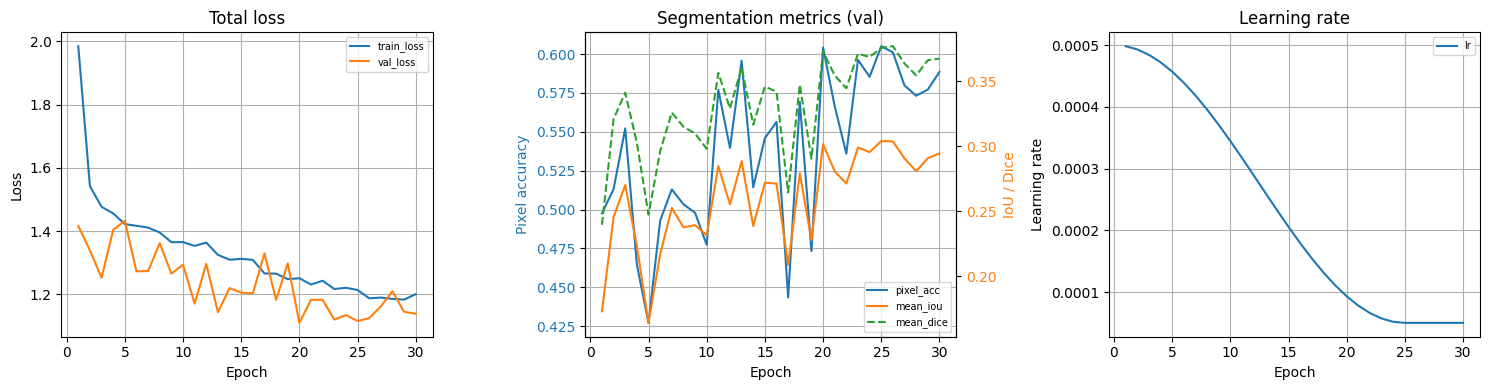

In [196]:
plot_curves(history, task="seg")

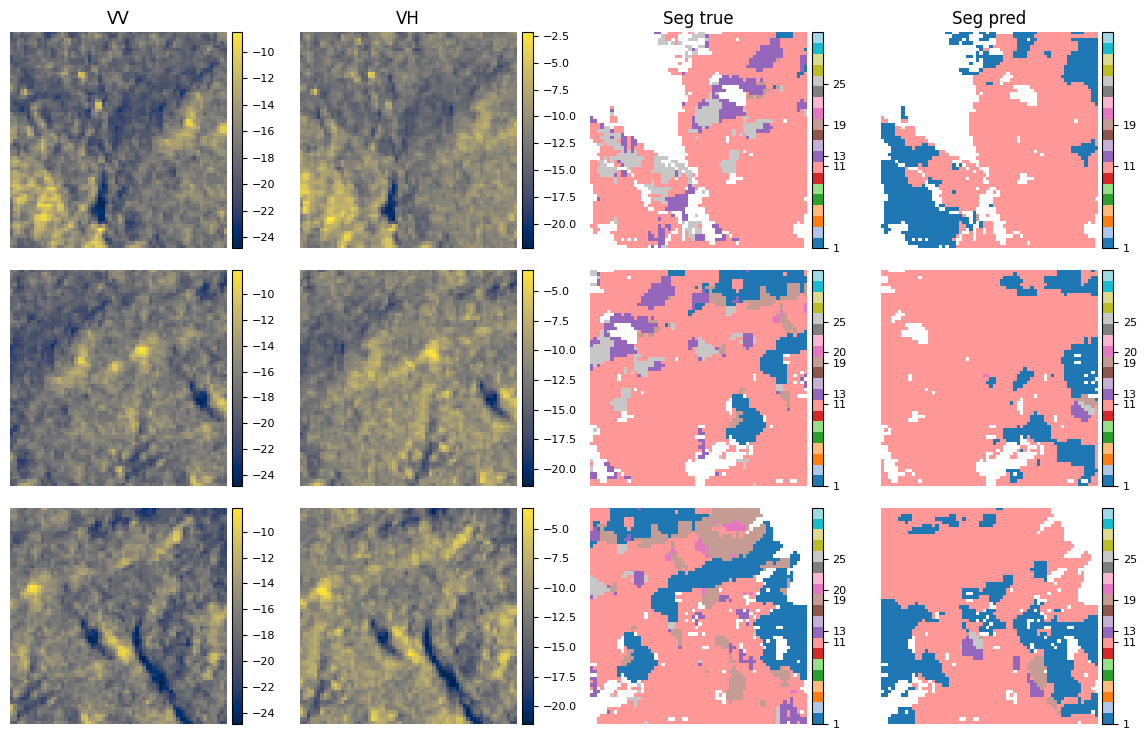

In [197]:
visualize_segmentation_samples(model, test_ds, 33, 3, device)

### Height Regression

In [168]:
configs.update(
    base_channels=128,
    max_lr=5e-4,
    base_lr=5e-5,
    weight_decay=1e-4,
    patience=5,
    dropout=0.2,
    epochs=100,
    scheduler="CosineAnnealingLR",
)

print(
    "base_channels:", configs["base_channels"],
    "\nmax_lr:", configs["max_lr"],
    "\nbase_lr:", configs["base_lr"],
    "\nweight_decay:", configs["weight_decay"],
    "\npatience:", configs["patience"],
    "\ndropout:", configs["dropout"],
    "\nepochs:", configs["epochs"],
    "\nscheduler:", configs["scheduler"],
)

model = RegressionUNet(
    in_channels=2,
    base_channels=configs["base_channels"],
    dropout=configs["dropout"],
).to(device)

reg_criterion = masked_rmse_loss
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=configs["max_lr"],
    weight_decay=configs["weight_decay"],
)

steps_per_epoch = max(len(train_loader), 1)
total_steps = steps_per_epoch * configs["epochs"]
if configs["scheduler"] == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps//4,
        eta_min=configs["base_lr"],
    )
else:
    scheduler = None

num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_height_rmse": [],
    "val_height_r2": [],
    "lr": []
}

base_channels: 128 
max_lr: 0.0005 
base_lr: 5e-05 
weight_decay: 0.0001 
patience: 5 
dropout: 0.2 
epochs: 100 
scheduler: CosineAnnealingLR


In [169]:
for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch_regression(
        model,
        train_loader,
        reg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
        target="height"
    )

    val_metrics = evaluate_regression(
        model,
        val_loader,
        reg_criterion,
        device,
        desc=f"Val Reg {epoch}",
        target="height"
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(train_metrics["loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_height_rmse"].append(val_metrics["height_rmse"])
    history["val_height_r2"].append(val_metrics["height_r2"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(
        f"Epoch {epoch}: train loss={train_metrics['loss']:.4f}, "
        f"val loss={val_metrics['loss']:.4f}, "
        f"RMSE={val_metrics['height_rmse']:.4f}, "
        f"R2={val_metrics['height_r2']:.4f}, "
        f"lr={optimizer.param_groups[0]['lr']}"
    )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break
    # if optimizer.param_groups[0]["lr"] < configs["base_lr"]+1e-6:
    #     scheduler = None

Val Reg 1: 100%|██████████| 19/19 [00:00<00:00, 89.26it/s]


Epoch 1: train loss=21.3942, val loss=27.1800, RMSE=27.8981, R2=-15.7807, lr=0.0004982258077957555
	Updated best model


Val Reg 2: 100%|██████████| 19/19 [00:00<00:00, 87.35it/s]


Epoch 2: train loss=18.3824, val loss=17.4485, RMSE=17.9933, R2=-5.9805, lr=0.0004929312112539372
	Updated best model


Val Reg 3: 100%|██████████| 19/19 [00:00<00:00, 89.79it/s]


Epoch 3: train loss=15.1763, val loss=13.8946, RMSE=14.3984, R2=-3.4698, lr=0.00048419970932485015
	Updated best model


Val Reg 4: 100%|██████████| 19/19 [00:00<00:00, 88.41it/s]


Epoch 4: train loss=11.9431, val loss=17.9662, RMSE=19.3881, R2=-7.1046, lr=0.0004721690030098632
	Patience 1/5


Val Reg 5: 100%|██████████| 19/19 [00:00<00:00, 88.81it/s]


Epoch 5: train loss=8.7264, val loss=7.2255, RMSE=7.5365, R2=-0.2246, lr=0.0004570288237343573
	Updated best model


Val Reg 6: 100%|██████████| 19/19 [00:00<00:00, 86.22it/s]


Epoch 6: train loss=6.8510, val loss=7.0305, RMSE=7.3709, R2=-0.1714, lr=0.0004390179411698117
	Updated best model


Val Reg 7: 100%|██████████| 19/19 [00:00<00:00, 84.61it/s]


Epoch 7: train loss=6.1517, val loss=6.4187, RMSE=6.5947, R2=0.0623, lr=0.00041842039769344986
	Updated best model


Val Reg 8: 100%|██████████| 19/19 [00:00<00:00, 86.38it/s]


Epoch 8: train loss=5.9993, val loss=6.9677, RMSE=7.6030, R2=-0.2463, lr=0.00039556102887026913
	Patience 1/5


Val Reg 9: 100%|██████████| 19/19 [00:00<00:00, 88.41it/s]


Epoch 9: train loss=6.0353, val loss=7.1271, RMSE=7.8537, R2=-0.3299, lr=0.0003708003406021362
	Patience 2/5


Val Reg 10: 100%|██████████| 19/19 [00:00<00:00, 89.47it/s]


Epoch 10: train loss=5.9468, val loss=7.0441, RMSE=7.7481, R2=-0.2944, lr=0.00034452882373435864
	Patience 3/5


Val Reg 11: 100%|██████████| 19/19 [00:00<00:00, 89.49it/s]


Epoch 11: train loss=5.9606, val loss=6.2888, RMSE=6.6305, R2=0.0521, lr=0.0003171607957817839
	Updated best model


Val Reg 12: 100%|██████████| 19/19 [00:00<00:00, 83.51it/s]


Epoch 12: train loss=5.9181, val loss=6.1893, RMSE=6.4289, R2=0.1089, lr=0.00028912786689409196
	Updated best model


Val Reg 13: 100%|██████████| 19/19 [00:00<00:00, 87.89it/s]


Epoch 13: train loss=5.8823, val loss=6.1426, RMSE=6.4540, R2=0.1019, lr=0.0002608721331059025
	Updated best model


Val Reg 14: 100%|██████████| 19/19 [00:00<00:00, 85.02it/s]


Epoch 14: train loss=5.8776, val loss=5.9965, RMSE=6.1386, R2=0.1875, lr=0.00023283920421821069
	Updated best model


Val Reg 15: 100%|██████████| 19/19 [00:00<00:00, 85.62it/s]


Epoch 15: train loss=5.7943, val loss=6.1293, RMSE=6.3155, R2=0.1400, lr=0.0002054711762656357
	Patience 1/5


Val Reg 16: 100%|██████████| 19/19 [00:00<00:00, 88.54it/s]


Epoch 16: train loss=5.8460, val loss=6.0777, RMSE=6.3135, R2=0.1406, lr=0.0001791996593978577
	Patience 2/5


Val Reg 17: 100%|██████████| 19/19 [00:00<00:00, 85.17it/s]


Epoch 17: train loss=5.8430, val loss=6.1119, RMSE=6.3148, R2=0.1402, lr=0.00015443897112972537
	Patience 3/5


Val Reg 18: 100%|██████████| 19/19 [00:00<00:00, 83.29it/s]


Epoch 18: train loss=5.7354, val loss=6.0438, RMSE=6.3291, R2=0.1363, lr=0.00013157960230654502
	Patience 4/5


Val Reg 19: 100%|██████████| 19/19 [00:00<00:00, 87.21it/s]

Epoch 19: train loss=5.7308, val loss=6.1073, RMSE=6.3728, R2=0.1244, lr=0.00011098205883018304
	Patience 5/5
Early stopping triggered


In [162]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics = evaluate_regression(
    model,
    test_loader,
    reg_criterion,
    device,
    desc="Test Reg",
    target="height"
)

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test Reg: 100%|██████████| 14/14 [00:00<00:00, 70.44it/s]



Test metrics:
  loss: 5.4069
  height_loss: 5.4069
  height_rmse: 5.4137
  height_r2: 0.2055


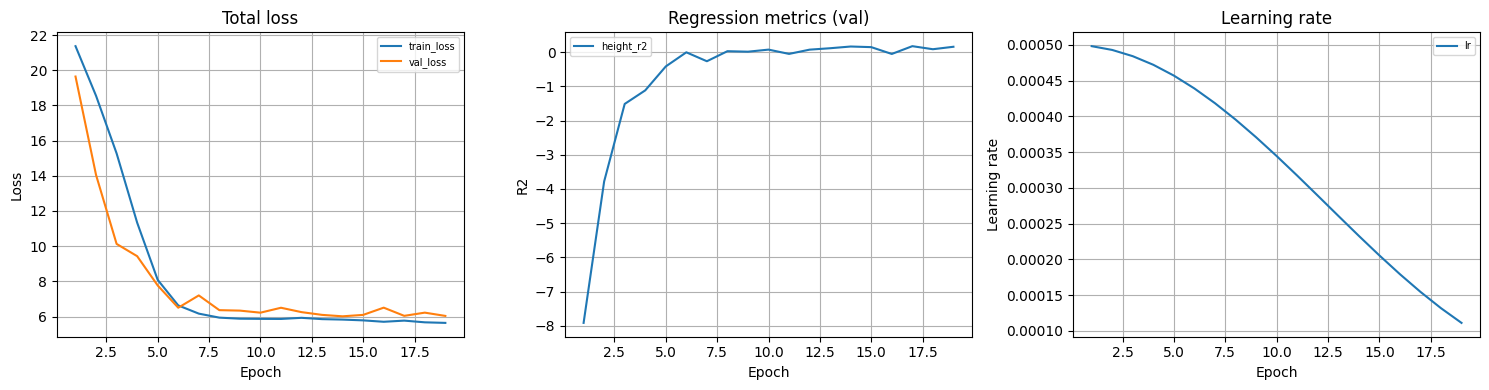

In [163]:
plot_curves(history, task="reg", target="height")

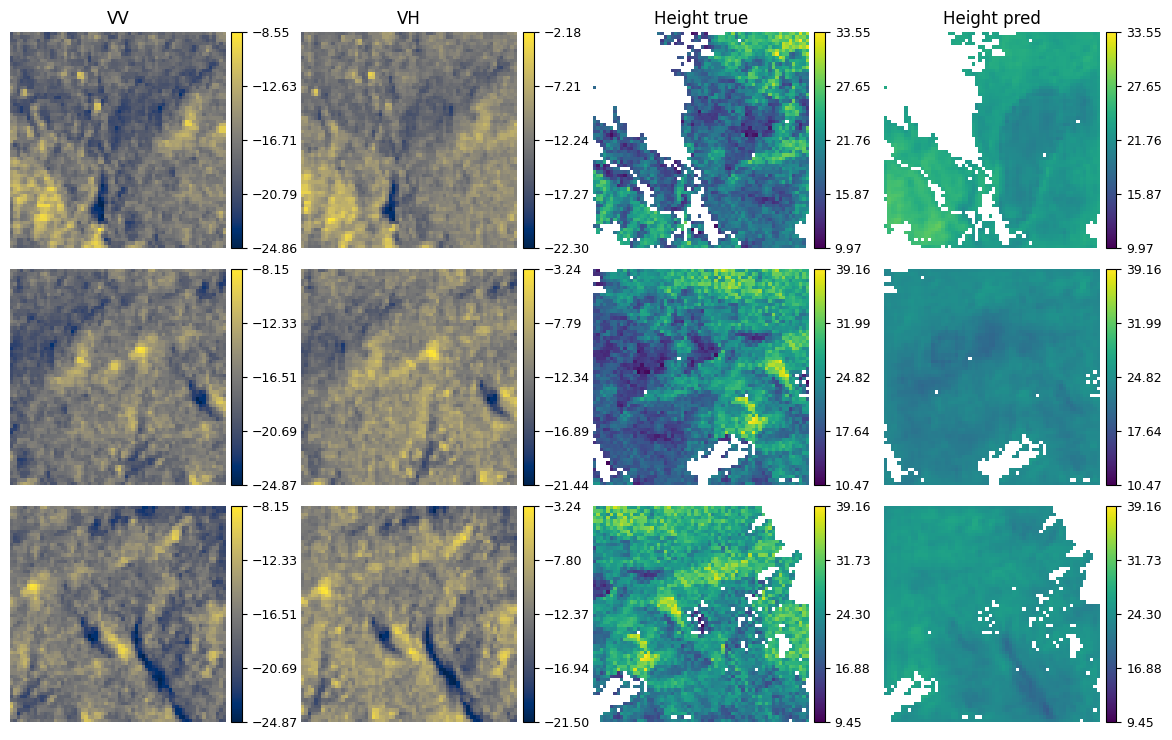

In [165]:
visualize_regression_samples(model, test_ds, 33, 3, device, target="height")

Collect reg pairs: 100%|██████████| 14/14 [00:00<00:00, 70.70it/s]


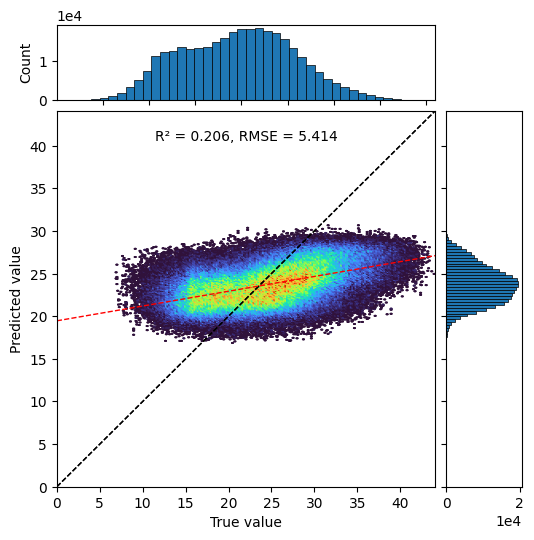

In [166]:
test_true, test_pred = collect_regression_pairs(model, loader=test_loader, device=device, target="height")
plot_regression_joint_with_hists(test_true, test_pred)

Collect reg pairs: 100%|██████████| 91/91 [00:00<00:00, 129.78it/s]
/tmp/ipython-input-3812053038.py:176: RankWarning: Polyfit may be poorly conditioned
  slope, intercept = np.polyfit(y_true, y_pred, 1)


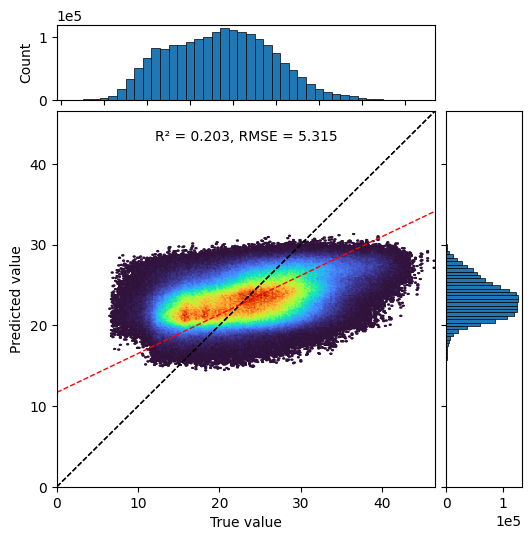

In [167]:
test_true, test_pred = collect_regression_pairs(model, loader=train_loader, target="height")
plot_regression_joint_with_hists(test_true, test_pred)

### Biomass Regression

In [171]:
configs.update(
    base_channels=128,
    max_lr=5e-4,
    base_lr=5e-5,
    weight_decay=1e-4,
    patience=10,
    dropout=0.2,
    epochs=100,
    scheduler="CosineAnnealingLR",
)

print(
    "base_channels:", configs["base_channels"],
    "\nmax_lr:", configs["max_lr"],
    "\nbase_lr:", configs["base_lr"],
    "\nweight_decay:", configs["weight_decay"],
    "\npatience:", configs["patience"],
    "\ndropout:", configs["dropout"],
    "\nepochs:", configs["epochs"],
    "\nscheduler:", configs["scheduler"],
)

model = RegressionUNet(
    in_channels=2,
    base_channels=configs["base_channels"],
    dropout=configs["dropout"],
).to(device)

reg_criterion = masked_rmse_loss
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=configs["max_lr"],
    weight_decay=configs["weight_decay"],
)

steps_per_epoch = max(len(train_loader), 1)
total_steps = steps_per_epoch * configs["epochs"]
if configs["scheduler"] == "CosineAnnealingLR":
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=total_steps//4,
        eta_min=configs["base_lr"],
    )
else:
    scheduler = None
num_epochs = configs["epochs"]
patience = configs["patience"]
best_val_loss = float("inf")
best_state = None
epochs_no_improve = 0

history = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
    "val_biomass_r2": [],
    "lr": []
}

base_channels: 128 
max_lr: 0.0005 
base_lr: 5e-05 
weight_decay: 0.0001 
patience: 10 
dropout: 0.2 
epochs: 100 
scheduler: CosineAnnealingLR


In [172]:
for epoch in range(1, num_epochs + 1):
    train_metrics = train_one_epoch_regression(
        model,
        train_loader,
        reg_criterion,
        optimizer,
        device,
        epoch=epoch,
        scheduler=scheduler,
        target="biomass"
    )

    val_metrics = evaluate_regression(
        model,
        val_loader,
        reg_criterion,
        device,
        desc=f"Val Reg {epoch}",
        target="biomass"
    )

    history["epoch"].append(epoch)
    history["train_loss"].append(train_metrics["loss"])
    history["val_loss"].append(val_metrics["loss"])
    history["val_biomass_r2"].append(val_metrics["biomass_r2"])
    history["lr"].append(optimizer.param_groups[0]["lr"])

    print(
        f"Epoch {epoch}: train loss={train_metrics['loss']:.4f}, "
        f"val loss={val_metrics['loss']:.4f}, "
        f"biomass R2={val_metrics['biomass_r2']:.4f}, "
        f"lr={optimizer.param_groups[0]['lr']}"
    )

    if val_metrics["loss"] < best_val_loss:
        best_val_loss = val_metrics["loss"]
        best_state = model.state_dict()
        epochs_no_improve = 0
        print("\tUpdated best model")
    else:
        epochs_no_improve += 1
        print(f"\tPatience {epochs_no_improve}/{patience}")

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break
    if optimizer.param_groups[0]["lr"] < configs["base_lr"]+1e-8:
        scheduler = None

Val Reg 1: 100%|██████████| 19/19 [00:00<00:00, 86.68it/s]


Epoch 1: train loss=75.9986, val loss=76.1822, biomass R2=-2.9527, lr=0.0004982258077957555
	Updated best model


Val Reg 2: 100%|██████████| 19/19 [00:00<00:00, 88.23it/s]


Epoch 2: train loss=72.9988, val loss=72.9318, biomass R2=-2.6196, lr=0.0004929312112539372
	Updated best model


Val Reg 3: 100%|██████████| 19/19 [00:00<00:00, 80.26it/s]


Epoch 3: train loss=69.0253, val loss=74.0260, biomass R2=-2.7325, lr=0.00048419970932485015
	Patience 1/10


Val Reg 4: 100%|██████████| 19/19 [00:00<00:00, 86.81it/s]


Epoch 4: train loss=64.2813, val loss=71.5844, biomass R2=-2.4809, lr=0.0004721690030098632
	Updated best model


Val Reg 5: 100%|██████████| 19/19 [00:00<00:00, 86.30it/s]


Epoch 5: train loss=59.0945, val loss=67.3941, biomass R2=-2.0597, lr=0.0004570288237343573
	Updated best model


Val Reg 6: 100%|██████████| 19/19 [00:00<00:00, 89.67it/s]


Epoch 6: train loss=53.6466, val loss=46.1216, biomass R2=-0.4389, lr=0.0004390179411698117
	Updated best model


Val Reg 7: 100%|██████████| 19/19 [00:00<00:00, 88.55it/s]


Epoch 7: train loss=49.0450, val loss=50.6125, biomass R2=-0.7279, lr=0.00041842039769344986
	Patience 1/10


Val Reg 8: 100%|██████████| 19/19 [00:00<00:00, 88.66it/s]


Epoch 8: train loss=44.9075, val loss=42.7789, biomass R2=-0.2384, lr=0.00039556102887026913
	Updated best model


Val Reg 9: 100%|██████████| 19/19 [00:00<00:00, 85.58it/s]


Epoch 9: train loss=42.7578, val loss=41.5966, biomass R2=-0.1630, lr=0.0003708003406021362
	Updated best model


Val Reg 10: 100%|██████████| 19/19 [00:00<00:00, 87.21it/s]


Epoch 10: train loss=41.0233, val loss=40.3959, biomass R2=-0.0926, lr=0.00034452882373435864
	Updated best model


Val Reg 11: 100%|██████████| 19/19 [00:00<00:00, 87.25it/s]


Epoch 11: train loss=40.0943, val loss=39.1165, biomass R2=-0.0295, lr=0.0003171607957817839
	Updated best model


Val Reg 12: 100%|██████████| 19/19 [00:00<00:00, 88.62it/s]


Epoch 12: train loss=39.2699, val loss=40.7980, biomass R2=-0.1226, lr=0.00028912786689409196
	Patience 1/10


Val Reg 13: 100%|██████████| 19/19 [00:00<00:00, 87.60it/s]


Epoch 13: train loss=39.2208, val loss=40.3498, biomass R2=-0.1103, lr=0.0002608721331059025
	Patience 2/10


Val Reg 14: 100%|██████████| 19/19 [00:00<00:00, 87.68it/s]


Epoch 14: train loss=38.7397, val loss=38.0364, biomass R2=0.0277, lr=0.00023283920421821069
	Updated best model


Val Reg 15: 100%|██████████| 19/19 [00:00<00:00, 85.95it/s]


Epoch 15: train loss=38.5106, val loss=40.0719, biomass R2=-0.0900, lr=0.0002054711762656357
	Patience 1/10


Val Reg 16: 100%|██████████| 19/19 [00:00<00:00, 88.10it/s]


Epoch 16: train loss=38.4713, val loss=38.0711, biomass R2=0.0255, lr=0.0001791996593978577
	Patience 2/10


Val Reg 17: 100%|██████████| 19/19 [00:00<00:00, 89.45it/s]


Epoch 17: train loss=38.1515, val loss=37.8911, biomass R2=0.0307, lr=0.00015443897112972537
	Updated best model


Val Reg 18: 100%|██████████| 19/19 [00:00<00:00, 88.44it/s]


Epoch 18: train loss=37.9554, val loss=38.8698, biomass R2=-0.0203, lr=0.00013157960230654502
	Patience 1/10


Val Reg 19: 100%|██████████| 19/19 [00:00<00:00, 87.50it/s]


Epoch 19: train loss=37.8362, val loss=37.6688, biomass R2=0.0452, lr=0.00011098205883018304
	Updated best model


Val Reg 20: 100%|██████████| 19/19 [00:00<00:00, 89.65it/s]


Epoch 20: train loss=37.7327, val loss=37.8037, biomass R2=0.0356, lr=9.297117626563719e-05
	Patience 1/10


Val Reg 21: 100%|██████████| 19/19 [00:00<00:00, 83.80it/s]


Epoch 21: train loss=37.4462, val loss=37.5764, biomass R2=0.0485, lr=7.783099699013089e-05
	Updated best model


Val Reg 22: 100%|██████████| 19/19 [00:00<00:00, 87.21it/s]


Epoch 22: train loss=37.2716, val loss=37.7717, biomass R2=0.0368, lr=6.580029067514362e-05
	Patience 1/10


Val Reg 23: 100%|██████████| 19/19 [00:00<00:00, 88.47it/s]


Epoch 23: train loss=37.3079, val loss=37.6395, biomass R2=0.0463, lr=5.706878874605806e-05
	Patience 2/10


Val Reg 24: 100%|██████████| 19/19 [00:00<00:00, 88.34it/s]


Epoch 24: train loss=37.2156, val loss=37.6277, biomass R2=0.0448, lr=5.1774192204242494e-05
	Patience 3/10


Val Reg 25: 100%|██████████| 19/19 [00:00<00:00, 79.67it/s] 


Epoch 25: train loss=37.1071, val loss=38.1971, biomass R2=0.0103, lr=5e-05
	Patience 4/10


Val Reg 26: 100%|██████████| 19/19 [00:00<00:00, 86.47it/s]


Epoch 26: train loss=37.0981, val loss=37.6617, biomass R2=0.0445, lr=5e-05
	Patience 5/10


Val Reg 27: 100%|██████████| 19/19 [00:00<00:00, 84.16it/s]


Epoch 27: train loss=37.0327, val loss=37.8315, biomass R2=0.0311, lr=5e-05
	Patience 6/10


Val Reg 28: 100%|██████████| 19/19 [00:00<00:00, 86.74it/s]


Epoch 28: train loss=36.8867, val loss=37.7041, biomass R2=0.0400, lr=5e-05
	Patience 7/10


Val Reg 29: 100%|██████████| 19/19 [00:00<00:00, 89.37it/s]


Epoch 29: train loss=36.7509, val loss=37.8966, biomass R2=0.0319, lr=5e-05
	Patience 8/10


Val Reg 30: 100%|██████████| 19/19 [00:00<00:00, 86.51it/s]


Epoch 30: train loss=36.7905, val loss=37.4200, biomass R2=0.0556, lr=5e-05
	Updated best model


Val Reg 31: 100%|██████████| 19/19 [00:00<00:00, 85.74it/s]


Epoch 31: train loss=36.5708, val loss=38.1426, biomass R2=0.0120, lr=5e-05
	Patience 1/10


Val Reg 32: 100%|██████████| 19/19 [00:00<00:00, 89.99it/s]


Epoch 32: train loss=36.7903, val loss=37.9062, biomass R2=0.0289, lr=5e-05
	Patience 2/10


Val Reg 33: 100%|██████████| 19/19 [00:00<00:00, 82.12it/s]


Epoch 33: train loss=36.6014, val loss=37.9063, biomass R2=0.0286, lr=5e-05
	Patience 3/10


Val Reg 34: 100%|██████████| 19/19 [00:00<00:00, 90.04it/s]


Epoch 34: train loss=36.4409, val loss=37.9451, biomass R2=0.0250, lr=5e-05
	Patience 4/10


Val Reg 35: 100%|██████████| 19/19 [00:00<00:00, 87.53it/s]


Epoch 35: train loss=36.5064, val loss=37.6812, biomass R2=0.0402, lr=5e-05
	Patience 5/10


Val Reg 36: 100%|██████████| 19/19 [00:00<00:00, 87.53it/s]


Epoch 36: train loss=36.3845, val loss=38.1999, biomass R2=0.0158, lr=5e-05
	Patience 6/10


Val Reg 37: 100%|██████████| 19/19 [00:00<00:00, 90.26it/s]


Epoch 37: train loss=36.2682, val loss=38.0978, biomass R2=0.0164, lr=5e-05
	Patience 7/10


Val Reg 38: 100%|██████████| 19/19 [00:00<00:00, 87.12it/s]


Epoch 38: train loss=36.2513, val loss=37.7215, biomass R2=0.0389, lr=5e-05
	Patience 8/10


Val Reg 39: 100%|██████████| 19/19 [00:00<00:00, 82.54it/s]


Epoch 39: train loss=36.3013, val loss=37.8616, biomass R2=0.0312, lr=5e-05
	Patience 9/10


Val Reg 40: 100%|██████████| 19/19 [00:00<00:00, 87.15it/s]

Epoch 40: train loss=36.0545, val loss=37.9791, biomass R2=0.0239, lr=5e-05
	Patience 10/10
Early stopping triggered


In [173]:
if best_state is not None:
    model.load_state_dict(best_state)

test_metrics = evaluate_regression(
    model,
    test_loader,
    reg_criterion,
    device,
    desc="Test Reg",
    target="biomass"
)

print("\nTest metrics:")
for k, v in test_metrics.items():
    print(f"  {k}: {v:.4f}")

Test Reg: 100%|██████████| 14/14 [00:00<00:00, 70.75it/s]



Test metrics:
  loss: 37.7162
  biomass_loss: 37.7162
  biomass_rmse: 39.0028
  biomass_r2: 0.0245


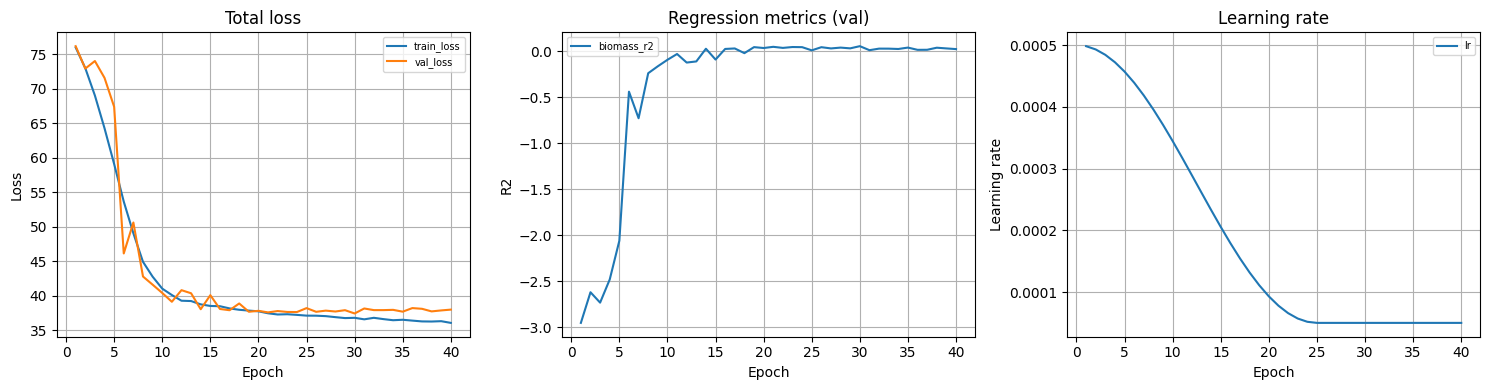

In [174]:
plot_curves(history, task="reg", target="biomass")

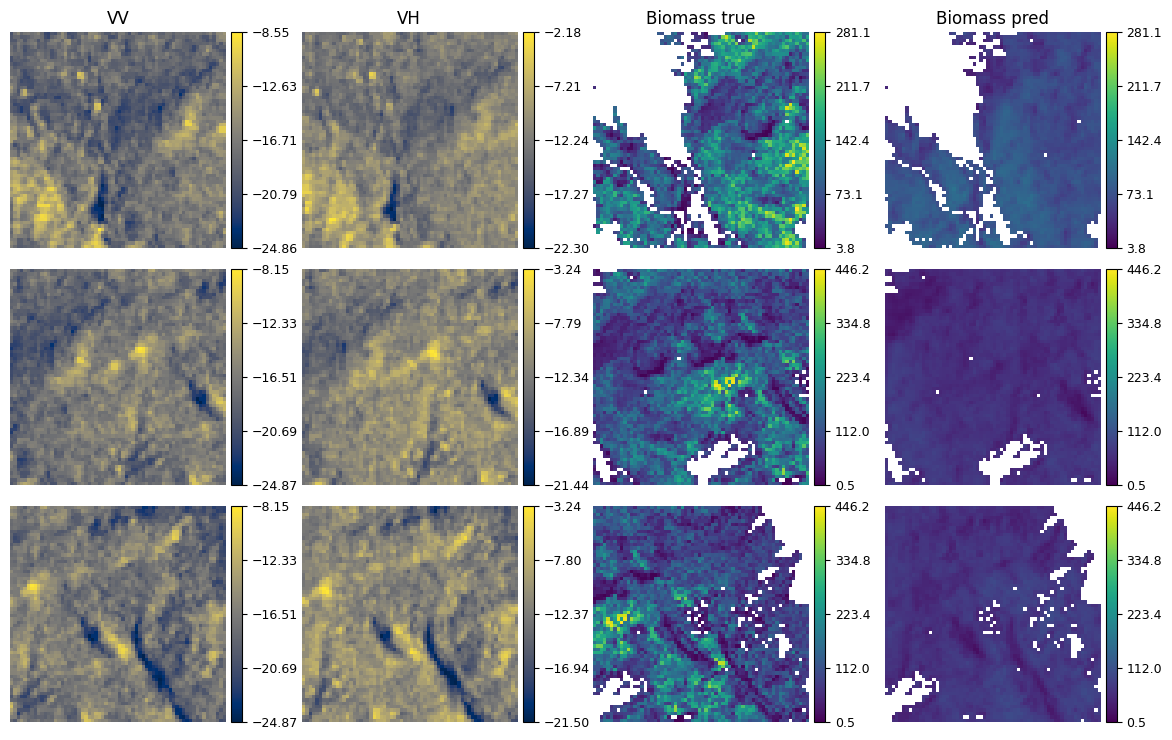

In [175]:
visualize_regression_samples(model, test_ds, 33, 3, device, target="biomass")

Collect reg pairs: 100%|██████████| 14/14 [00:00<00:00, 67.07it/s]


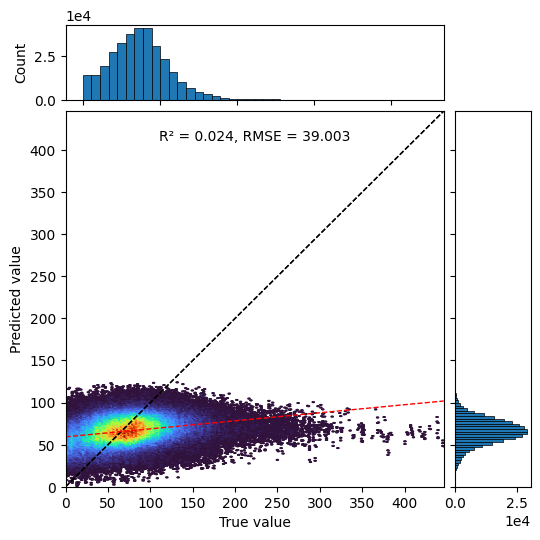

In [176]:
test_true, test_pred = collect_regression_pairs(model, test_loader, target="biomass")
plot_regression_joint_with_hists(test_true, test_pred)

Collect reg pairs: 100%|██████████| 91/91 [00:00<00:00, 129.16it/s]


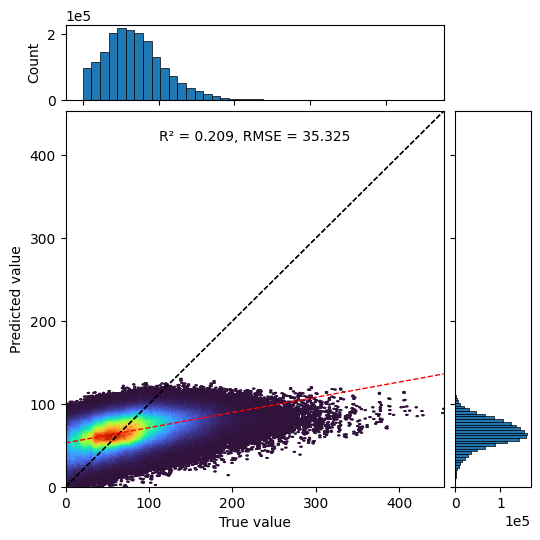

In [177]:
test_true, test_pred = collect_regression_pairs(model, train_loader, target="biomass")
plot_regression_joint_with_hists(test_true, test_pred)